<a href="https://colab.research.google.com/github/Ashikur-ai/Learn-Tensorflow/blob/main/10_saving_the_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Saving and Loading Models 
In this tutorial we will learn how we can take a trained model, save it, and then load it back to keep training it or use it to perform inference. In particular, we will use transfer learning to train a classifier to classify images of cats and dogs, just like we did in the previous lesson. We will then take our trained model and save it as an HDF5 file, which is the format used by Keras. We will then load this model, use it to perform predictions, and then continue to train the model. Finally, we will save our trained model as a TensorFlow SavedModel and then we will download it to a local disk, so that can later be used for deployment in different platforms.


#Concepts that will be covered in this Colab
1.Saving models in HDF5 format for Keras
2. Saving models in the TensorFlow SavedModel format
3. Loading models
4. Download models to Local Disk



#Imports 
In this Colab we will use the TensorFlow 2.0

In [2]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from tensorflow.keras import layers

#Part 1: Load the Cats vs. Dogs Dataset
We will use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [3]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


The images in the Dogs vs. Cats dataset are not all the same size. So, we need to reformat all images to the resolution expected by MobileNet(224, 224)

In [4]:
def format_image(image, label):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

#Part 2:Transfer Learning with TensorFlow Hub
We will now use TensorFlow Hub to do Transfer Learning.

In [5]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Freeze the variables in the feature extractor layer, so that the training only modifies the final clasifier layer.

In [6]:
feature_extractor.trainable = False

#Attach a classification head
Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [7]:
model= tf.keras.Sequential([
    feature_extractor,
    layers.Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


#Train the model
We now train this model like any other, by first calling `compile` followed by `fit`

In [8]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 1
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

582/582 [==============================] - 613s 1s/step - loss: 0.0553 - accuracy: 0.9813 - val_loss: 0.0317 - val_accuracy: 0.9882


#Check the predictions
Get the ordered list of class names.

In [12]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run an image batch through the model and convert the indices to class names.

In [14]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch - tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog',
       'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog',
       'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog',
       'cat', 'dog', 'dog', 'cat', 'dog'], dtype='<U3')

Let's look at the true labels and predicted ones.

In [15]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1]
Predicted labels:  [1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1]


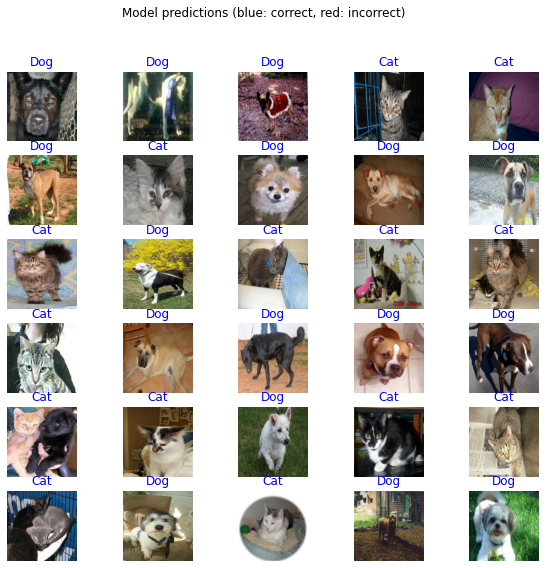

In [18]:
plt.figure(figsize=(10, 9))
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

#Part 3: Save as Keras `.h5`  model
Now that we've trained the model, we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension '.h5', and it's name will correpond to the current time stamp.

In [19]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1660460478.h5


In [20]:
!ls

'~'   1660460478.h5   sample_data


You can later recreate the same model from this file, even if you no longer have access to the created the model.

This file includes:
* The model's architecture
* The model's weight value (which were learned during training)
* The model's training config(what you passedc to `compile`), if any
* The optimizer and its state, if any (this enables you to restart training where you left off)

#Part 4: Load the Keras `.h5` Model
We will now load the model we just saved into a new model called `reloaded`. We will need to provide the file path and the `custom_objects` parameter. This parameter tells keras how to load the `how.KerasLayer` from the `feature_extractor` we used for transfer learning.

In [21]:
reloaded = tf.keras.models.load_model(
    export_path_keras,
    #`custom_object` tells keras how to laod a `hub.KerasLayer`
    custom_objects = {'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


We can check that the reloaded model and the previous model give the same result


In [22]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)


The difference in output should be zero:

In [23]:
(abs(result_batch - reloaded_result_batch)).max()


0.0

As we can see, the result is 0.0, which indicates that both models made the same predictions on the same batch of images.

#Keep Training
Besides making predictions, we can also take our `reloaded` model and keep training it. To do this, you can just train the `reloaded` as usual, using th `.fit` method.

In [24]:
EPOCHS = 1
history = reloaded.fit(train_batches,
                       epochs=EPOCHS,
                       validation_data=validation_batches)

582/582 [==============================] - 628s 1s/step - loss: 0.0305 - accuracy: 0.9903 - val_loss: 0.0339 - val_accuracy: 0.9873


#Part 5: Export as SavedModel
Yo can also export a whole model to the TensorFlow SavedModel format. SavedModel is a standalone serialization format for Tensorflow objects, supported by TensorFlow serving as weel as Tensorflow implementations other than Python. A SavedModel contains a complete TensorFlow program, including weights and computation. It does not require the original moel building code to run, which makes it useful for sharing or deploying (wiht TFLite, TensorFlow.js, TensorFlow Serving, or TFHub).

The SavedModel files that were created contain:
* A TensorFlow checkpoint containing the model weights.
* A SavedModel proto containing the underlying Tensorflow graph. Separate graphs are saved for prediction (serving), train, and evaluation. If the model wasn'tcompiled before, then only the inference graph gets exported.
* The model's architectu8re congig, if available.

Liet's save our original `model` as a TensorFlow SavedModel. To do this we will use the `tf.saved_model.save()` function. Ths functions takes in the model we want to save and the path to the folder where we want to save our model. 
This function will create a folder where you will find an `assets` folder, a `variables`folder, and the `saved-model.pb`file.

In [25]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1660464806


In [26]:
!ls {export_path_sm}

assets	saved_model.pb	variables


#Part 6: Load SavedModel

Now, let's load our SavedModel and use it to make predictions. We use the `tf.save4d_model.load()` function to load our SavedModels. The object returned by `tf.saved_model.load`is 100% independent of the code that created it.

In [27]:
reloaded_sm = tf.saved_model.load(export_path_sm)

Now, let's use the `reloaded_sm` (reloaded SavedModel) to make predictions on a batch of images.

In [29]:
reload_sm_result_batch = reloaded_sm(image_batch, training=False).numpy()

We can check that the reloaded SavedModel and the previous model give the same result.

In [30]:
abs((result_batch - reload_sm_result_batch)).max()

0.0

As we can see, the result is 0.0, which indicates that both models made the same predictions on the same batch of images.

#Part 7: Loading the SavedModel as a Keras Model
The object returned by `tf.saved_model.load` is not a Keras object (i.e. doesn'thave `.fit`, `.predict`, `.summary`, etc. methods). Therefore, you can't simply take your `reloaded_sm` model and keep training it by running `.fit`. To be able to get back a full keras model from the Tensorflow SavedModel format we must use the `tf.keras.models.load_model` function. This function will work the same as before, except now we pass the path to the folder containing our SavedModel.

In [31]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1660465456


#Part 8: Download your model
You can download the SavedModel to your local disk by creating a zip file. We will use the `-r`(recursice) option to zip all subfoldels.

In [35]:
!zip -r model.zip {export_path_sm}

  adding: 1660465456/ (stored 0%)
  adding: 1660465456/assets/ (stored 0%)
  adding: 1660465456/saved_model.pb (deflated 92%)
  adding: 1660465456/variables/ (stored 0%)
  adding: 1660465456/variables/variables.index (deflated 78%)
  adding: 1660465456/variables/variables.data-00000-of-00001 (deflated 8%)


The zip file is saved in the current working directory. You can see what the current working directory is by running:

In [36]:
!ls

'~'   1660460478.h5   1660464806   1660465456   model.zip   sample_data


Once the file is zipped, you can download it to your local disk.

In [38]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The `files.download` command will search for files in you7r current working directory. If the file you want to download is in a directory other that the current working directory, you have to include the path to the directory where the file is located.